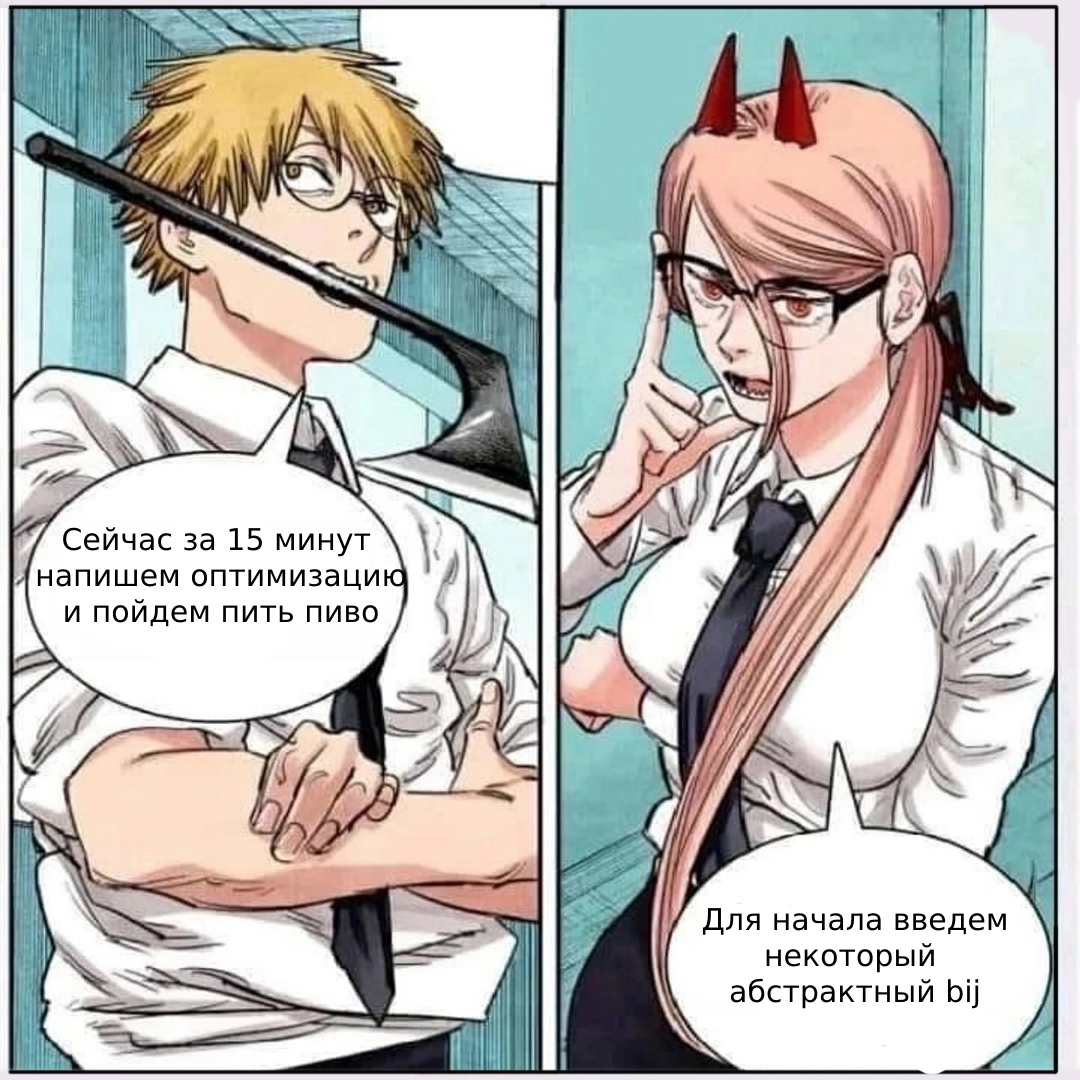

In [1]:
# we have to set env variable to use propack, if we want to use sparse2tuck
import os
os.environ["SCIPY_USE_PROPACK"] = "1"
import torch
import numpy as np
import tucker_riemopt
from tucker_riemopt import backend as back
from tucker_riemopt import set_backend
from tucker_riemopt.tucker.tucker import Tucker
from tucker_riemopt.sf_tucker.sf_tucker import SFTucker
import tucker_riemopt.sf_tucker.riemannian as riemann
from scipy.special import expit
from tqdm import tqdm
set_backend("pytorch")
from time import time

# Example of Tucker Riemaniannian optimization

###### Basic working tensors 
* $\text{Omega_dense} \approx I(0,1) $ is dense mask tensor 
* $\text{Omega_tucker}$ is Tucker representation of mask tensor
* $\text{X_dense} \approx R(0,1)$ is first target tensor approximation (dense tensor)
* $\text{X_tucker}$ is Tucker representation of first approximation

###### Examples of target tensors
* $\text{Sin_dense}(i_1,\ldots,i_d) = sin(i_1 + \ldots + i_d)$ is 2-rank target tensor 
* $\text{Sin_tucker}$ is Tucker representation of Sinus tensor
* $\text{Hilbert_dense}(i_1,\ldots,i_d) = \frac{1}{i_1 + \ldots + i_d + d}$ is target tensor with exponentially decaying singular numbers
* $\text{Hilbert_tucker}$ is Tucker representation of Hilbert tensor

In [ ]:
#init tensors and mask
size = 64

Sin_dense     = back.zeros([size,size,size])
# Hilbert_dense = back.zeros([size,size,size])
# Omega_dense   = back.zeros([size,size,size])
# X_dense       = back.zeros([size,size,size])

for i in range(size):
    for j in range(size):
        for k in range(size):
            Sin_dense[i][j][k]     = np.sin(i + j + k)
#             Hilbert_dense[i][j][k] = 1 / (i + j + k + 3)
#             Omega_dense[i][j][k]   = 1 if np.random.uniform() < 0.01 else 0
#             X_dense[i][j][k]       = np.random.uniform()

# Omega_tucker = Tucker.from_dense(Omega_dense)
Sin_tucker   = Tucker.from_dense(Sin_dense)
# X_tucker     = Tucker.from_dense(X_dense)

In [120]:
def Omega_projection(dense_tensor, Omega = Omega_dense):
    #Projection onto known tensor elements, given by dense Omega tensor
    #elementwise product
    return dense_tensor * Omega

def Tucker_Omega_projection(tucker_tensor, Omega = Omega_tucker):
    #Projection tensor given by tucker-format onto known tensor elements, given by dense Omega tensor
    #elementwise product in Tucker format
    return Tucker.from_dense(Omega_projection(tucker_tensor.to_dense()))

def Euclidean_grad(X, Target_tensor = Sin_tucker):
    return Tucker_Omega_projection(Target_tensor) - Tucker_Omega_projection(X)

def f(X, A = Sin_tucker):
    return 1/2 * (Tucker_Omega_projection(A) - Tucker_Omega_projection(X)).norm() ** 2

def line_search(eta, X):
    proj_eta = Tucker_Omega_projection(eta)
    return proj_eta.flat_inner(Euclidean_grad(X)) / (proj_eta.norm() ** 2)

def retraction(X, xi, r):
    return (X + xi).round([r, r, r])


In [4]:
xi,fx    = riemann.grad(f, X_tucker)
xi       = xi.construct()
eta      = -xi
alpha    = line_search(eta, X_tucker)
X_tucker = retraction(X_tucker, alpha * eta, 2)

In [5]:
max_iter = 150

for k in range(max_iter):
    betta = 1/(xi).norm()
    xi,fx = riemann.grad(f, X_tucker)
    xi = xi.construct()
    betta *=(xi).norm()
    eta   = -xi + betta*riemann.project(X_tucker, eta).construct()
    alpha = line_search(eta, X_tucker)
    X_tucker     = retraction(X_tucker, alpha*eta, 2)
    eps = back.sqrt(2*fx) / Sin_tucker.norm()
    
    if k % 50 == 0:
        print(round(float(eps),5))
    if eps < 1e-2:
        break

0.12124
0.08936
0.08711


In [6]:
print("Relative error: ||A-X||/||A|| ",round(float((Sin_dense - X_tucker.to_dense()).norm()/Sin_dense.norm()),5))

Relative error: ||A-X||/||A||  1.16606


# Knowledge graphs

#### FB15-237 dataset

In [70]:
#Датасет качать отсюда ->  https://www.kaggle.com/datasets/huihuixu/fb15k-237
class Data:
    def __init__(self, data_dir="data/", reverse=False):
        self.train_data = self.load_data(data_dir, "train", reverse=reverse)
        self.valid_data = self.load_data(data_dir, "valid", reverse=reverse)
        self.test_data = self.load_data(data_dir, "test", reverse=reverse)
        self.data = self.train_data + self.valid_data + self.test_data
        self.entities = self.get_entities(self.data)
        self.train_relations = self.get_relations(self.train_data)
        self.valid_relations = self.get_relations(self.valid_data)
        self.test_relations = self.get_relations(self.test_data)
        self.relations = self.train_relations + [i for i in self.valid_relations \
                if i not in self.train_relations] + [i for i in self.test_relations \
                if i not in self.train_relations]
        self.entity_idxs = {self.entities[i]:i for i in range(len(self.entities))}
        self.relation_idxs = { self.relations[i]:i for i in range(len( self.relations))}
        
    def load_data(self, data_dir, data_type="train", reverse=False):
        with open("%s%s.txt" % (data_dir, data_type), "r") as f:
            data = f.read().strip().split("\n")
            data = [i.split() for i in data]
            if reverse:
                data += [[i[2], i[1]+"_reverse", i[0]] for i in data]
        return data

    def get_relations(self, data):
        relations = sorted(list(set([d[1] for d in data])))
        return relations

    def get_entities(self, data):
        entities = sorted(list(set([d[0] for d in data]+[d[2] for d in data])))
        return entities
    
    def get_data_idxs(self, data):
        data_idxs = [(self.entity_idxs[data[i][0]], self.relation_idxs[data[i][1]], \
                      self.entity_idxs[data[i][2]]) for i in range(len(data))]
        return data_idxs
    
    def get_tensor(self,data):
        idxs = self.get_data_idxs(data)
        N = len(self.entities)
        Rel = len(self.train_relations)
        Tensor = np.zeros([N,Rel,N], dtype =np.int8)
        for idx in idxs:
            Tensor[idx] = 1
        return Tensor

#usage example
N    = 1000#len(data.entities)   #bound on sampl and entities number
data = Data() #load data

dataset_idxs = data.get_data_idxs(data.train_data) #get train tensor indicies
dataset_idxs  = list(filter(lambda x: x[0] <= N and x[2] <= N, dataset_idxs))

# A = data.get_tensor(data.train_data) #get train tensor
# A[dataset_idxs[1245]] #check correct values

#### LOGLOSS FUCTIONAL (crossentropy)

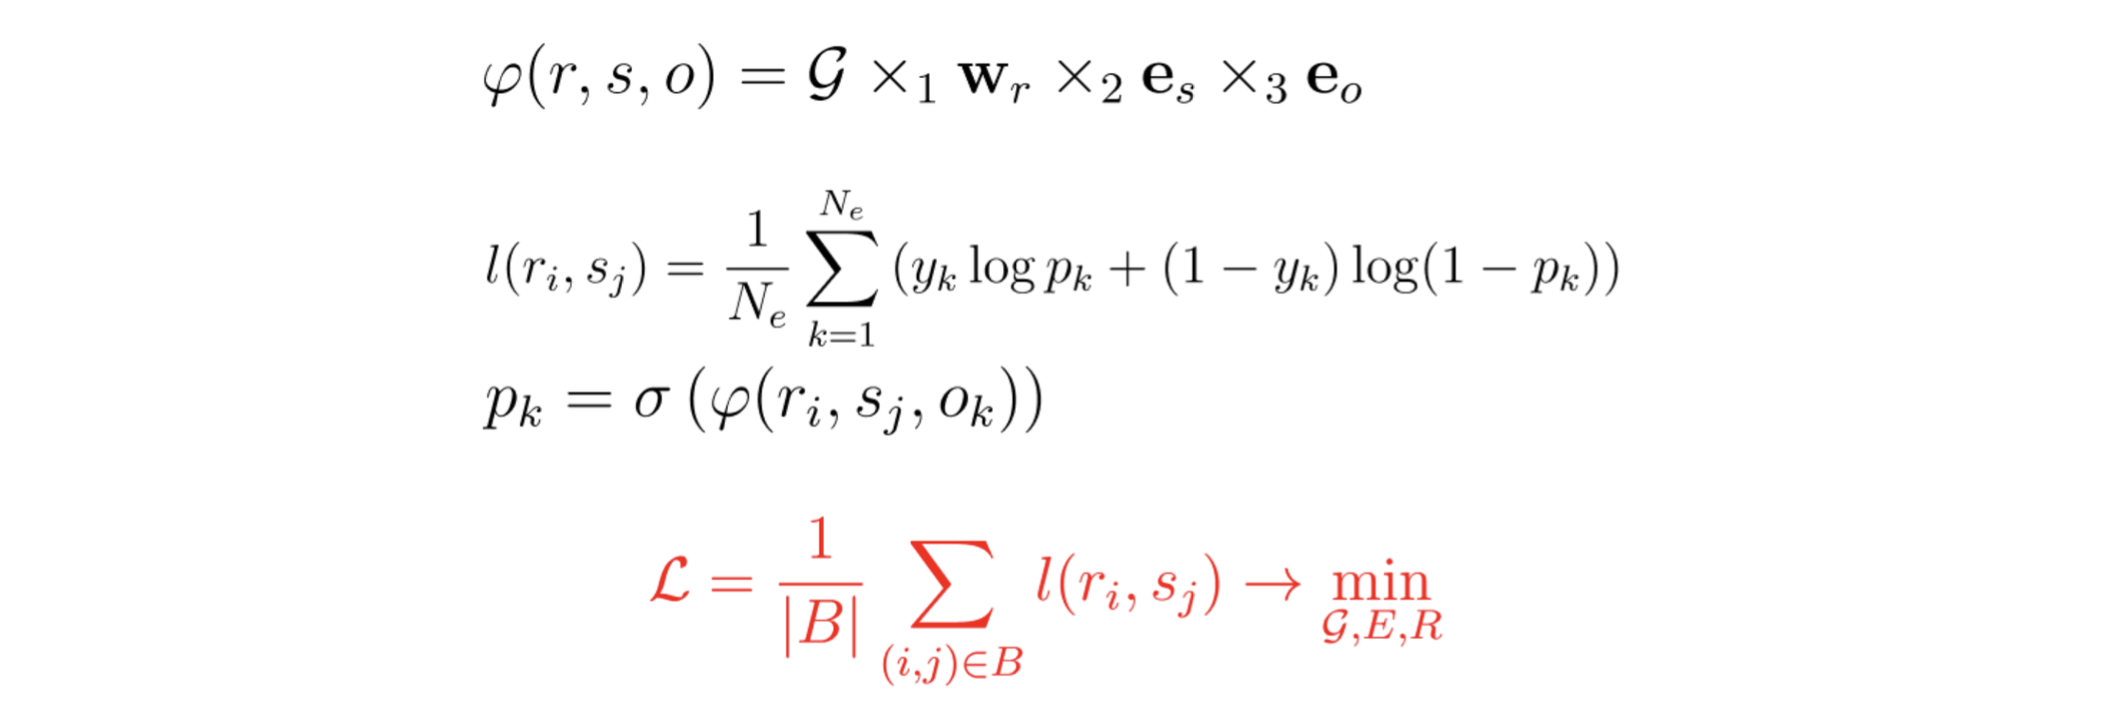

In [85]:
#for whole row along index k 
def sigmoid(Tucker_tensor,i,j):
    G = Tucker_tensor.core
#     U,V,W = Tucker_tensor.factors
    V = Tucker_tensor.factors[0]
    U = Tucker_tensor.shared_factor
    W = U
    return 1/(1+torch.exp(-(back.einsum("jik,i,j,nk->n", G, U[i],V[j], W))))

#local entropy along yk vector
def l(Tucker_tensor,y, i,j):
    res = 0.0
    y = y.clone().detach()
    tolerance = 1e-7
#     N = Tucker_tensor.shape[-1]
    p = sigmoid(Tucker_tensor, i, j)
    return -1/N*(y@torch.log(p + tolerance) + (1 - y)@torch.log(1 - p + tolerance))

#returns vector y on train tensor corresponding index i, j along the dimension k
def get_y(idxs, i, j, Ne):
    res = torch.zeros(Ne)
    ones = list(filter(lambda x: x[0]==i and x[1]==j ,idxs))
    if ones !=[]:
        ones = np.array(ones)[:, 2]
        for pos in ones:
            res[pos] = 1
    return res

#Crossentropy
def L(Tucker_tensor):
    global bij
    global idxs
    global B
    I = bij #np.array(idxs)[:,0:2]
    res = 0.0
    for i, j in I:
        res += l(Tucker_tensor, get_y(idxs, i, j, N), i, j)
    return res / len(I)

def get_batch(X_tucker, idxs):
    G = X_tucker.core
    U,V,W = X.factors
    U_cut = U[list(set(np.array(idxs)[:,0]))]
    V_cut = V[list(set(np.array(idxs)[:,1]))]
    return Tucker(G,[U_cut, V_cut,W])

def retraction(X, xi, r):
    return (X + xi).round(r)

def armijo(X,r,fx, xi,eta, alpha0):
    beta = 1/2
    c = 1e-4
    for m in range(10000):
        alpha = alpha0*(beta)**m
        print(fx - L(retraction(X,alpha*eta, r)), -c*xi.flat_inner(alpha*eta))
        if fx - L(retraction(X,alpha*eta, r)) >= -c*xi.flat_inner(alpha*eta):
            return alpha, m
        
def unique(idxs,B, i):
    batch = idxs[i*B:(i+1)*B]
    batch = list(set(batch))
    batch = np.array(batch)[:,:2]
    return batch

In [86]:
#initial condationps point

#random filling
re, rs = 20, 10
Ne = N
Nr = len(data.relations)
G = torch.rand((rs, re, re))
# G = torch.rand((re, rs, re)) * 10
#G = back.tensor([np.kron(np.kron(i, j), k) for i in range(re) for j in range(rs) for k in range(re)]).reshape(re, rs, re)
#G = back.tensor([np.sin(i + j + k) for i in range(re) for j in range(rs) for k in range(re)]).reshape(re, rs, re)
# U = back.tensor([1/(i + j+1) for i in range(Ne) for j in range(re)]).reshape(Ne, re)
# V = back.tensor([1/(i + j+1) for i in range(Nr) for j in range(rs)]).reshape(Nr, rs)
U, _ = np.linalg.qr(np.random.randn(Ne, re))
V, _ = np.linalg.qr(np.random.randn(Nr, rs))
U = back.tensor(U, dtype = torch.float)
V = back.tensor(V, dtype = torch.float)
# U,V  = torch.zeros((N, 20))+1 , torch.zeros((Rel, 10))+1
X = SFTucker(G, factors=[V], shared_factor=U)
#sinus (small dimension)
Nes, Nrs = 64, Nr
X_s =  SFTucker.from_dense(back.tensor([1.0/(i + j + k + 1) for i in range(Nes) for j in range(Nrs) for k in range(Nes)]).reshape(Nes, Nrs, Nes)).round([re, rs, re])
sin_idxs = np.random.randint(0, Nes - 1, size = [20, 3])

In [91]:
def riemmanian_CG(X, loss, r, B = 64, num_of_iter = 100):
    global bij
    Nr, Ne, _ = X.shape
#     batch_j = range(Nr)
#     batch_i = range(B)
#     batch = [(a, b) for a in batch_i for b in batch_j]
    bij      = unique(idxs,B, 0)
    xi,fx    = riemann.grad(loss, X)
    xi       = xi.construct() - X
    eta      = -xi
    alpha    = 1e-3
    X        = retraction(X, alpha * eta, r)
    print("number of batch ", Ne // B)
    for k in range(num_of_iter):
        print("epoch = ", k)
        start = time()
        for i in tqdm(range(Ne // B)):
#             batch_i = [i for i in range(B*i, B*(i+1))]
#             batch = [(a, b) for a in batch_i for b in batch_j]
            bij      = unique(idxs,B, i)
            betta = 1/(xi).norm()
            xi,fx    = riemann.grad(loss, X)
            xi       = xi.construct() - X
            print(xi.norm())
            betta *=(xi).norm()
            eta   = -xi + betta*riemann.project(X, eta).construct()
#             eta      = - xi
            alpha    = 1e-3 #1e8
#             alpha,m    = armijo(X,r, fx, xi, eta, alpha)
            X        = retraction(X, alpha * eta, r)
#             print(m)
        bij = unique(idxs, Ne, 0)
        epoch_loss = loss(X)
        print(f"alpha {alpha}   loss: {epoch_loss}   time: {time() - start}")
        if (epoch_loss < 1e-7):
            break
B = 100
num_of_iter = 10
idxs = dataset_idxs
Ne, Nr, _ = X_s.shape

riemmanian_CG(X, L, [rs, re, re], B, num_of_iter)

number of batch  10
epoch =  0


  0%|                                                    | 0/10 [00:00<?, ?it/s]

tensor(37.0182)


 10%|████▍                                       | 1/10 [00:00<00:06,  1.41it/s]

tensor(37.0922)


 20%|████████▊                                   | 2/10 [00:01<00:05,  1.46it/s]

tensor(37.2035)


 30%|█████████████▏                              | 3/10 [00:01<00:04,  1.57it/s]

tensor(37.3523)


 40%|█████████████████▌                          | 4/10 [00:02<00:03,  1.51it/s]

tensor(37.5391)


 50%|██████████████████████                      | 5/10 [00:03<00:03,  1.51it/s]

tensor(37.7643)


 60%|██████████████████████████▍                 | 6/10 [00:04<00:03,  1.31it/s]

tensor(38.0287)


 70%|██████████████████████████████▊             | 7/10 [00:05<00:02,  1.19it/s]

tensor(38.3329)


 80%|███████████████████████████████████▏        | 8/10 [00:06<00:02,  1.02s/it]

tensor(38.6779)


 90%|███████████████████████████████████████▌    | 9/10 [00:07<00:00,  1.03it/s]

tensor(39.0646)


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.15it/s]


alpha 0.001   loss: 0.6931465268135071   time: 9.059345960617065
epoch =  1


  0%|                                                    | 0/10 [00:00<?, ?it/s]

tensor(39.4944)


 10%|████▍                                       | 1/10 [00:01<00:09,  1.07s/it]

tensor(39.9683)


 20%|████████▊                                   | 2/10 [00:01<00:07,  1.08it/s]

tensor(40.4879)


 30%|█████████████▏                              | 3/10 [00:02<00:06,  1.05it/s]

tensor(41.0547)


 40%|█████████████████▌                          | 4/10 [00:03<00:05,  1.15it/s]

tensor(41.6705)


 50%|██████████████████████                      | 5/10 [00:04<00:04,  1.10it/s]

tensor(42.3372)


 60%|██████████████████████████▍                 | 6/10 [00:05<00:03,  1.06it/s]

tensor(43.0570)


 70%|██████████████████████████████▊             | 7/10 [00:06<00:02,  1.01it/s]

tensor(43.8320)


 80%|███████████████████████████████████▏        | 8/10 [00:07<00:01,  1.01it/s]

tensor(44.6648)


 90%|███████████████████████████████████████▌    | 9/10 [00:08<00:00,  1.07it/s]

tensor(45.5581)


100%|███████████████████████████████████████████| 10/10 [00:09<00:00,  1.05it/s]


alpha 0.001   loss: 0.6931464672088623   time: 9.924262046813965
epoch =  2


  0%|                                                    | 0/10 [00:00<?, ?it/s]

tensor(46.5148)


 10%|████▍                                       | 1/10 [00:01<00:09,  1.10s/it]

tensor(47.5381)


 20%|████████▊                                   | 2/10 [00:01<00:07,  1.13it/s]

tensor(48.6315)


 30%|█████████████▏                              | 3/10 [00:03<00:09,  1.34s/it]

tensor(49.7987)


 40%|█████████████████▌                          | 4/10 [00:04<00:07,  1.23s/it]

tensor(51.0436)


 50%|██████████████████████                      | 5/10 [00:05<00:05,  1.17s/it]

tensor(52.3708)


 60%|██████████████████████████▍                 | 6/10 [00:06<00:04,  1.12s/it]

tensor(53.7848)


 70%|██████████████████████████████▊             | 7/10 [00:08<00:03,  1.14s/it]

tensor(55.2907)


 80%|███████████████████████████████████▏        | 8/10 [00:08<00:01,  1.00it/s]

tensor(56.8941)


 90%|███████████████████████████████████████▌    | 9/10 [00:09<00:00,  1.00it/s]

tensor(58.6010)


100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.05s/it]


alpha 0.001   loss: 0.6931477189064026   time: 10.938460111618042
epoch =  3


  0%|                                                    | 0/10 [00:00<?, ?it/s]

tensor(60.4176)


 10%|████▍                                       | 1/10 [00:00<00:06,  1.31it/s]

tensor(62.3510)


 20%|████████▊                                   | 2/10 [00:01<00:05,  1.38it/s]

tensor(64.4085)


 30%|█████████████▏                              | 3/10 [00:02<00:05,  1.40it/s]

tensor(66.5984)


 40%|█████████████████▌                          | 4/10 [00:02<00:04,  1.43it/s]

tensor(68.9293)


 50%|██████████████████████                      | 5/10 [00:03<00:03,  1.41it/s]

tensor(71.4108)


 60%|██████████████████████████▍                 | 6/10 [00:04<00:02,  1.37it/s]

tensor(74.0530)


 70%|██████████████████████████████▊             | 7/10 [00:05<00:02,  1.38it/s]

tensor(76.8670)


 80%|███████████████████████████████████▏        | 8/10 [00:05<00:01,  1.42it/s]

tensor(79.8648)


 90%|███████████████████████████████████████▌    | 9/10 [00:06<00:00,  1.43it/s]

tensor(83.0594)


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.40it/s]


alpha 0.001   loss: 0.6931496858596802   time: 7.530589818954468
epoch =  4


  0%|                                                    | 0/10 [00:00<?, ?it/s]

tensor(86.4648)


 10%|████▍                                       | 1/10 [00:01<00:12,  1.37s/it]

tensor(90.0963)


 20%|████████▊                                   | 2/10 [00:02<00:07,  1.02it/s]

tensor(93.9704)


 30%|█████████████▏                              | 3/10 [00:02<00:05,  1.18it/s]

tensor(98.1051)


 40%|█████████████████▌                          | 4/10 [00:03<00:05,  1.08it/s]

tensor(102.5198)


 50%|██████████████████████                      | 5/10 [00:04<00:04,  1.00it/s]

tensor(107.2357)


 60%|██████████████████████████▍                 | 6/10 [00:05<00:03,  1.11it/s]

tensor(112.2757)


 70%|██████████████████████████████▊             | 7/10 [00:06<00:02,  1.20it/s]

tensor(117.6649)


 80%|███████████████████████████████████▏        | 8/10 [00:07<00:01,  1.18it/s]

tensor(123.4305)


 90%|███████████████████████████████████████▌    | 9/10 [00:08<00:00,  1.14it/s]

tensor(129.6019)


100%|███████████████████████████████████████████| 10/10 [00:09<00:00,  1.07it/s]


alpha 0.001   loss: 0.6931551694869995   time: 9.821263074874878
epoch =  5


  0%|                                                    | 0/10 [00:00<?, ?it/s]

tensor(136.2116)


 10%|████▍                                       | 1/10 [00:00<00:06,  1.39it/s]

tensor(143.2946)


 20%|████████▊                                   | 2/10 [00:01<00:05,  1.35it/s]

tensor(150.8892)


 30%|█████████████▏                              | 3/10 [00:02<00:05,  1.33it/s]

tensor(159.0371)


 40%|█████████████████▌                          | 4/10 [00:02<00:04,  1.34it/s]

tensor(167.7841)


 50%|██████████████████████                      | 5/10 [00:03<00:03,  1.36it/s]

tensor(177.1800)


 60%|██████████████████████████▍                 | 6/10 [00:04<00:02,  1.40it/s]

tensor(187.2792)


 70%|██████████████████████████████▊             | 7/10 [00:05<00:02,  1.41it/s]

tensor(198.1413)


 80%|███████████████████████████████████▏        | 8/10 [00:05<00:01,  1.44it/s]

tensor(209.8316)


 90%|███████████████████████████████████████▌    | 9/10 [00:07<00:00,  1.06it/s]

tensor(222.4214)


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.25it/s]


alpha 0.001   loss: 0.6931755542755127   time: 8.435804843902588
epoch =  6


  0%|                                                    | 0/10 [00:00<?, ?it/s]

tensor(235.9890)


 10%|████▍                                       | 1/10 [00:00<00:06,  1.42it/s]

tensor(250.6203)


 20%|████████▊                                   | 2/10 [00:01<00:05,  1.43it/s]

tensor(266.4092)


 30%|█████████████▏                              | 3/10 [00:02<00:04,  1.44it/s]

tensor(283.4594)


 40%|█████████████████▌                          | 4/10 [00:02<00:04,  1.40it/s]

tensor(301.8842)


 50%|██████████████████████                      | 5/10 [00:03<00:03,  1.28it/s]

tensor(321.8085)


 60%|██████████████████████████▍                 | 6/10 [00:04<00:03,  1.17it/s]

tensor(343.3695)


 70%|██████████████████████████████▊             | 7/10 [00:05<00:02,  1.22it/s]

tensor(366.7184)


 80%|███████████████████████████████████▏        | 8/10 [00:06<00:01,  1.23it/s]

tensor(392.0218)


 90%|███████████████████████████████████████▌    | 9/10 [00:06<00:00,  1.30it/s]

tensor(419.4631)


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


alpha 0.001   loss: 0.6932598352432251   time: 8.063431978225708
epoch =  7


  0%|                                                    | 0/10 [00:00<?, ?it/s]

tensor(449.2447)


 10%|████▍                                       | 1/10 [00:00<00:06,  1.40it/s]

tensor(481.5901)


 20%|████████▊                                   | 2/10 [00:01<00:05,  1.47it/s]

tensor(516.7458)


 30%|█████████████▏                              | 3/10 [00:02<00:04,  1.41it/s]

tensor(554.9849)


 40%|█████████████████▌                          | 4/10 [00:02<00:04,  1.44it/s]

tensor(596.6082)


 50%|██████████████████████                      | 5/10 [00:03<00:03,  1.42it/s]

tensor(641.9501)


 60%|██████████████████████████▍                 | 6/10 [00:04<00:02,  1.43it/s]

tensor(691.3798)


 70%|██████████████████████████████▊             | 7/10 [00:04<00:02,  1.42it/s]

tensor(745.3068)


 80%|███████████████████████████████████▏        | 8/10 [00:06<00:02,  1.04s/it]

tensor(804.1854)


 90%|███████████████████████████████████████▌    | 9/10 [00:07<00:00,  1.01it/s]

tensor(868.5197)


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]


alpha 0.001   loss: 0.6936622858047485   time: 8.747770071029663
epoch =  8


  0%|                                                    | 0/10 [00:00<?, ?it/s]

tensor(938.8692)


 10%|████▍                                       | 1/10 [00:00<00:06,  1.41it/s]

tensor(1015.8557)


 20%|████████▊                                   | 2/10 [00:01<00:05,  1.37it/s]

tensor(1100.1708)


 30%|█████████████▏                              | 3/10 [00:02<00:05,  1.35it/s]

tensor(1192.5841)


 40%|█████████████████▌                          | 4/10 [00:02<00:04,  1.36it/s]

tensor(1293.9529)


 50%|██████████████████████                      | 5/10 [00:03<00:03,  1.35it/s]

tensor(1405.2316)


 60%|██████████████████████████▍                 | 6/10 [00:04<00:02,  1.38it/s]

tensor(1527.4856)


 70%|██████████████████████████████▊             | 7/10 [00:05<00:02,  1.39it/s]

tensor(1661.9030)


 80%|███████████████████████████████████▏        | 8/10 [00:05<00:01,  1.40it/s]

tensor(1809.8110)


 90%|███████████████████████████████████████▌    | 9/10 [00:06<00:00,  1.34it/s]

tensor(1972.6927)


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]


alpha 0.001   loss: 0.6958984136581421   time: 7.734297037124634
epoch =  9


  0%|                                                    | 0/10 [00:00<?, ?it/s]

tensor(2152.2058)


 10%|████▍                                       | 1/10 [00:00<00:06,  1.33it/s]

tensor(2350.2065)


 20%|████████▊                                   | 2/10 [00:01<00:05,  1.38it/s]

tensor(2568.7734)


 30%|█████████████▏                              | 3/10 [00:02<00:05,  1.38it/s]

tensor(2810.2361)


 40%|█████████████████▌                          | 4/10 [00:02<00:04,  1.34it/s]

tensor(3077.2053)


 50%|██████████████████████                      | 5/10 [00:03<00:03,  1.35it/s]

tensor(3372.6145)


 60%|██████████████████████████▍                 | 6/10 [00:04<00:03,  1.27it/s]

tensor(3699.7542)


 70%|██████████████████████████████▊             | 7/10 [00:05<00:02,  1.14it/s]

tensor(4062.3259)


 80%|███████████████████████████████████▏        | 8/10 [00:06<00:01,  1.06it/s]

tensor(4464.4917)


 90%|███████████████████████████████████████▌    | 9/10 [00:07<00:00,  1.15it/s]

tensor(4910.9360)


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.23it/s]


alpha 0.001   loss: 0.7099570035934448   time: 8.545446157455444


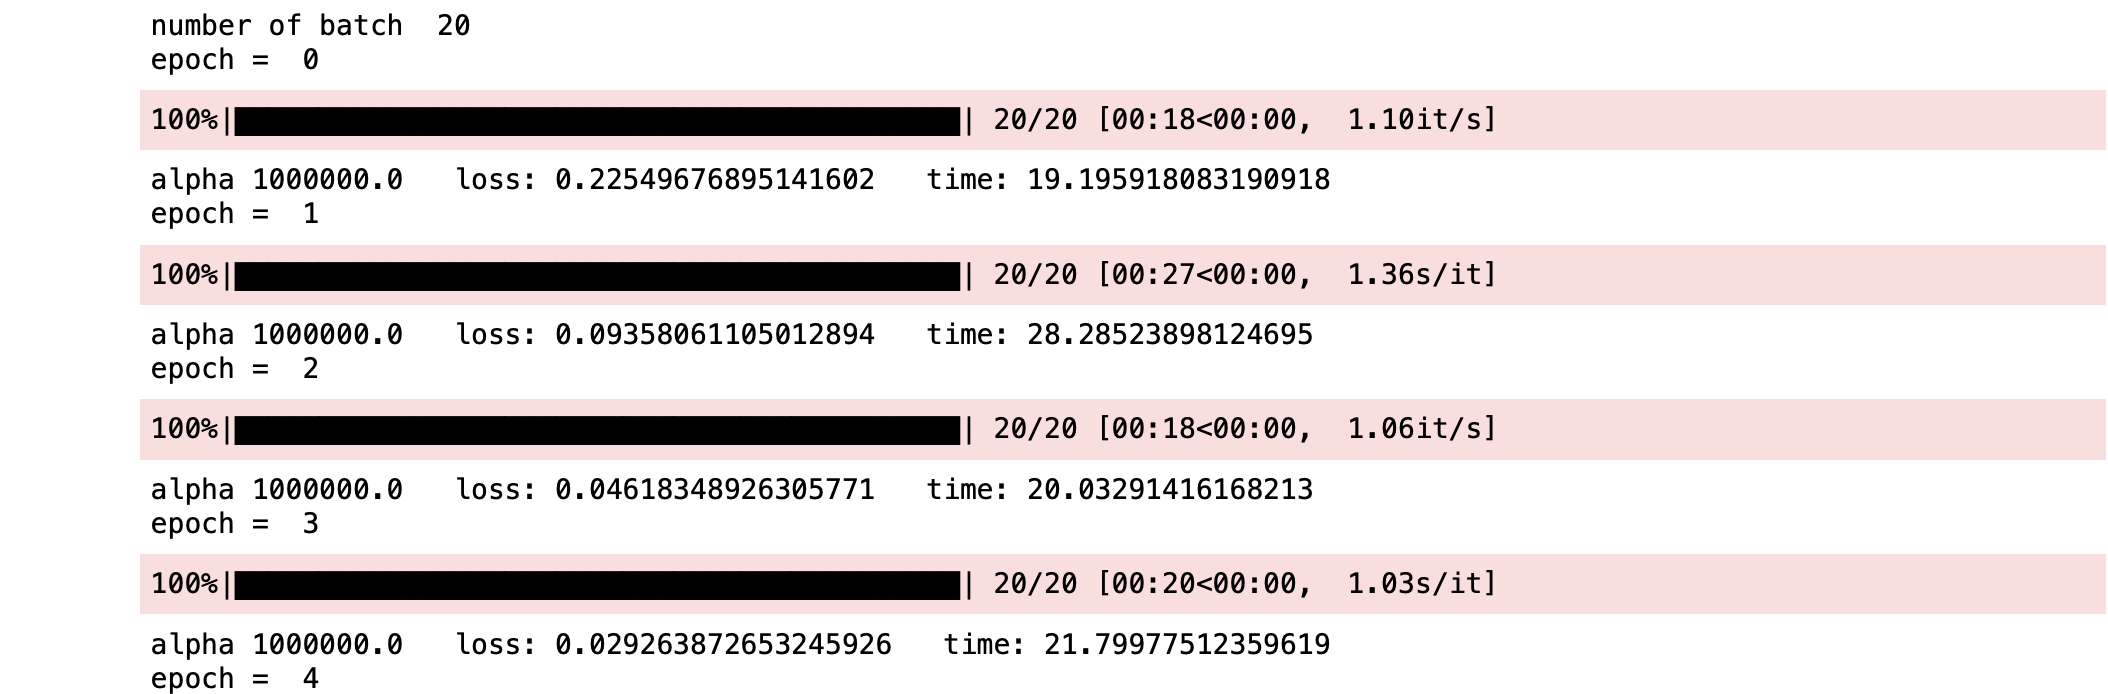

------

# Путник, не ходи этой дорогой, там тебя ждет лишь хаос

In [117]:
# a = np.random.randint(0,2,[64,64,64])
b = back.tensor(torch.randint(0,50,[64,64,64]))#back.zeros([64,64,64])+99
b_tucker = Tucker.from_dense(b)

In [118]:
L(b_tucker, sin_idxs)

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 958.87it/s]


tensor(8.1498)

In [119]:
xi,fx    = riemann.grad(L, b_tucker)
xi       = xi.construct()
xi.norm()

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 139.51it/s]


tensor(0.0149)

## applied projection to each rank 

In [36]:
def get_triplet(core,v1,v2,v3, r1,r2,r3,Omega):
    return core[r1][r2][r3]*back.einsum("ijk,i,j,k->ijk",Omega, v1[:,r1],v2[:,r2],v3[:,r3])
def proj(tucker_tensor,R1,R2,R3, Omega=Omega_dense):
    res = back.zeros(tucker_tensor.shape)
    for r1 in range(R1):
        for r2 in range(R2):
            for r3 in range(R3):
                res += get_triplet(tucker_tensor.core,*tucker_tensor.factors, r1, r2, r3, Omega_dense)
    return Tucker.from_dense(res)

## Create list of sparse matrix

In [208]:
#Tried to use sparseTensor, but get bad results
three = []
size = 128
nnz = 300
Omega =back.zeros([size,size,size],dtype=int)
for i in range(nnz):
    three.append(tuple(np.random.randint(0, size,(3))))
    Omega[three[-1][0]][three[-1][1]][three[-1][2]]=1

In [209]:
def sp_pr(Sin_dense, three):    
    ZERO = back.zeros(Sin_dense.shape)
    vals = []
    for ind in three:
        ZERO[ind[0]][ind[1]][ind[2]] = Sin_dense[ind[0]][ind[1]][ind[2]]
        vals.append(Sin_dense[ind[0]][ind[1]][ind[2]])
    return ZERO, vals

In [270]:
def q(three,sparse_dense):
#     sparse_tensor = tucker_riemopt.SparseTensor([128,128,128],np.array(three).T,vals)
    sparse_tensor = tucker_riemopt.SparseTensor.dense2sparse(sparse_dense)
    r=Tucker.sparse2tuck(sparse_tensor,[128,128,128])
    return r

In [271]:
sparse_dense, vals=sp_pr(Sin_dense, three)

In [272]:
%time tensor = q(three,sparse_dense)

CPU times: user 1min 7s, sys: 10.7 s, total: 1min 18s
Wall time: 19.3 s


In [164]:
#made just for fun
def hadamard_product(t1,t2):
    core = back.kron(t1.core, t2.core)
    factor0 = back.khatri_rao([t1.factors[0], t2.factors[0]]).T
    factor1 = back.khatri_rao([t1.factors[1], t2.factors[1]]).T
    factor2 = back.khatri_rao([t1.factors[2], t2.factors[2]]).T
    return Tucker(core, [factor0,factor1,factor2])